In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import numpy as np
import shapely.geometry as shpgeo
from osmread import parse_file, Node, Way, Relation
import datetime
import osm_helper
from osm_helper import node2pt, way2line, rltn2poly, osm_container
from collections import defaultdict
pdidx = pd.IndexSlice
%matplotlib inline

In [2]:
DCOSM_DATA_PATH = '../data/washingtonDC.osm'
OUTPUT_DIR = '../data/output/'

In [3]:
OSM_DATA = osm_container(DCOSM_DATA_PATH)
print OSM_DATA.data_size()

begin reading osm 2016-10-31 22:26:23.785000
finish reading osm 2016-10-31 22:27:34.875000
["len of <class 'osmread.elements.Relation'> = 3427", "len of <class 'osmread.elements.Way'> = 306332", "len of <class 'osmread.elements.Node'> = 2546260"]


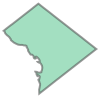

In [4]:
reload(osm_helper)
relation = OSM_DATA.get_osm_relation_by_id(162069)
dc_boundary = rltn2poly(OSM_DATA, relation)
dc_lon, dc_lat = dc_boundary.centroid.coords[0]
dc_boundary

In [10]:
with open('../data/dc_polygon.geojson','w') as f:
    f.write(gp.GeoDataFrame([dc_boundary],columns=['geometry']).to_json())

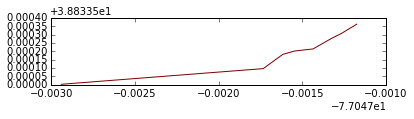

In [5]:
gp.GeoDataFrame([osm_helper.way2line(OSM_DATA,OSM_DATA.osm_objs[Way][0])],columns=['geometry']).plot()

In [6]:
def get_dc_nodes(nodes, dc_boundary):
    print datetime.datetime.now()
    dc_nodes = []
    for node in nodes:
        pt = node2pt(node)
        if pt.intersects(dc_boundary):
            dc_nodes.append(node)
    print datetime.datetime.now()
    return dc_nodes

def get_dc_ways(ways, dc_boundary):
    print datetime.datetime.now()
    dc_ways = []
    way_with_one_node = []
    for way in ways:
        if way.nodes.__len__()>1:
            ln = way2line(OSM_DATA, way)
            if ln.intersects(dc_boundary):
                dc_ways.append(way)
        else:
            way_with_one_node.append(way)
    print datetime.datetime.now()
    return dc_ways

In [7]:
DC_NODES = get_dc_nodes(OSM_DATA.osm_objs[Node], dc_boundary)
DC_WAYS = get_dc_ways(OSM_DATA.osm_objs[Way], dc_boundary)

2016-10-29 21:35:16.900000
2016-10-29 21:40:18.739000
2016-10-29 21:40:18.739000
2016-10-29 21:41:21.008000


In [21]:
TAGS_OF_INTEREST=set(['access', 'amenity', 'area', 'atm', 'barrier', 'bicycle', 'bicycle_parking', 'border_type', 'boundary', 'bridge', 'building', 'building:level', 'building:material', 'building:part', 'bus', 'city', 'club', 'construction', 'country', 'crossing', 'cuisine', 'cycleway', 'cycleway:right', 'denomination', 'destination', 'diplomatic', 'ele', 'electrified', 'floating', 'food', 'foot', 'footway', 'gauge', 'golf', 'height', 'highway', 'historic', 'historic', 'horse', 'junction', 'landuse', 'lanes', 'lanes:backward', 'lanes:forward', 'layer', 'lcn', 'leisure', 'level', 'man_made', 'maxspeed', 'motor_vehicle', 'natural', 'NHS', 'note:lanes', 'office', 'oneway', 'opening_hours', 'operator', 'parking', 'place', 'railway', 'railway', 'religion', 'religion', 'service', 'SHAPE_AREA', 'SHAPE_LEN', 'shelter', 'shop', 'sidewalk', 'smoking', 'sport', 'state', 'surface', 'takeaway', 'tourism', 'traffic_calming', 'tunnel', 'turn:lanes', 'turn:lanes:backward', 'turn:lanes:forward', 'usage', 'voltage', 'water', 'waterway', 'wheelchair', 'width', 'Zoo'])

In [28]:
def filter_osm_objs_by_tags(osm_objs, tags_of_interest):
    filter_osm_objs = []
    for obj in osm_objs:
        tags = set((obj.tags.keys()))
        if len(tags&tags_of_interest)>0:
            filter_osm_objs.append(obj)
    return filter_osm_objs

DC_NODES_FILTER = filter_osm_objs_by_tags(DC_NODES, TAGS_OF_INTEREST)
DC_WAYS_FILTER = filter_osm_objs_by_tags(DC_WAYS, TAGS_OF_INTEREST)

In [8]:
for n in DC_NODES:
    if 'dataset' in n.tags:
        print n
        break

Node(id=367141885L, version=2, changeset=38587038, timestamp=1460724555, uid=989960, tags={u'addr:housenumber': u'1630', u'amenity': u'doctors', u'gnis:county_name': u'District of Columbia', u'name': u'Childrens Adams Morgan Health Center', u'gnis:reviewed': u'no', u'addr:state': u'DC', u'dataset': u'address', u'dcgis:square': u'2572', u'dcgis:lot': u'0815', u'source': u'USGS Geonames;dcgis', u'gnis:import_uuid': u'57871b70-0100-4405-bb30-88b2e001a944', u'gnis:feature_id': u'2457478', u'ele': u'57', u'addr:street': u'Euclid Street Northwest'}, lon=-77.0379906, lat=38.9230244)


In [9]:
def get_objs_by_tag(objs, tag, tag_to_exclude=''):
    of_interest = [e for e in entities if tag in e.tags]
    return of_interest

def get_dc_nodes_by_tag(tag, tag_to_exclude=''):
    return get_objs_by_tag(DC_NODES, tag, tag_to_exclude)

def get_dc_ways_by_tag(tag, tag_to_exclude=''):
    return get_objs_by_tag(DC_WAYS, tag, tag_to_exclude)

In [10]:
def get_tags_from_objs(osm_objs):
    result=[]
    for n in osm_objs:
        if n.tags:
            oid = n.id
            for key, value in n.tags.items():
                result.append((key, value, oid))
    return pd.DataFrame(result, columns=['tag','value','oid'])

def get_statistic(tags_in_osm_objs):
    len_with_tags = len(set(tags_in_osm_objs.oid))
    tags_cnt = tags_in_osm_objs.groupby(['tag']).agg('count').sort('oid',ascending=False)
    tags_cnt = tags_cnt.drop('value',axis=1)
    tags_cnt.columns = ['cnt']
    tags_cnt['pct.']=tags_cnt.cnt/len_with_tags
    tags_cnt['cum'] = tags_cnt['pct.'].cumsum()
    
    tags_value_cnt = tags_in_osm_objs.groupby(['tag','value']).agg('count').sort('oid', ascending=False)
    tags_value_cnt.columns = ['cnt']
    tags_value_cnt['pct.']=tags_value_cnt.cnt/len_with_tags
    tags_value_cnt['cum'] = tags_value_cnt['pct.'].cumsum()
    return tags_cnt, tags_value_cnt, len_with_tags
def df_for_each_tag(tags_in_order, tags_value_cnt):
    df_list = []
    for tag in tags_in_order:
        values = tags_value_cnt.loc[tag].copy()
        len_osm_objs = values.cnt.sum()
        len_values = values.shape[0]
        
        # percentage: len(nodes with tag=value)/len(nodes with tag=*)
        values['pct.'] = values.cnt/len_osm_objs
        values['cum'] = values['pct.'].cumsum()
        df_list.append((tag, values))
    return df_list

## How many plots
1. separate plots of cumsum of each value in a tag
2. [tags, tag-value pairs, one html for all separate tag] \* [cumsum, ~~hist~~, pct.] \* [all tags, selected tags]

In [15]:
import plotly
import plotly.graph_objs as go

In [24]:
OUTPUT_DIR_FOR_GRAPH = OUTPUT_DIR+'OSM tags graphs/'

def plot_tags_value_cnt(tags_value_cnt, len_objs, otype, tags_of_interest=[]):
    tags_value_cnt_copy = tags_value_cnt
    if len(tags_of_interest)>0:
        tags_value_cnt_copy = tags_value_cnt.sort_index().loc[pdidx[tags_of_interest,:],:].sort('cnt',ascending=False)
    x_pct = ['%s=%s' %(tag, value) for tag, value in tags_value_cnt_copy.index.tolist()]
    y_pct = tags_value_cnt_copy['pct.'].values.tolist()
    plotly.offline.plot({"data":[go.Bar(x=x_pct, y=y_pct)], 
                         "layout":go.Layout(title='percentage of tag=value in {} {}'.format(len_objs, otype))},
                       filename=OUTPUT_DIR_FOR_GRAPH+'tags_value_pct_{1}{0}.html'.format(len_objs, otype))
    
#     x_cumpct = ['']+x_pct
#     y_cumpct = tags_value_cnt['cum'].values.tolist()
#     plotly.offline.plot({"data":[go.Scatter(x=x_cumpct, y=y_cumpct)], 
#                          "layout":go.Layout(title="cumulative percentage of tag=value in {} {}".format(len_objs, otype))},
#                     filename=OUTPUT_DIR_FOR_GRAPH+"tags_value_cumpct_%s.html" % otype)
    
    
def plot_tags_cnt(tags_cnt, len_objs, otype, tags_of_interest=[]):
    tags_cnt_copy = tags_cnt
    if len(tags_of_interest)>0:
        tags_cnt_copy = tags_cnt.loc[tags_of_interest].dropna().copy().sort('cnt', ascending=False)
    x_pct = tags_cnt_copy.index.tolist()
    y_pct = tags_cnt_copy['pct.'].values.tolist()
    plotly.offline.plot({"data":[go.Bar(x=x_pct, y=y_pct)], 
                         "layout":go.Layout(title='percentage of tags in {} {}'.format(len_objs, otype))},
                       filename=OUTPUT_DIR_FOR_GRAPH+'tags_pct_{1}{0}.html'.format(len_objs, otype))

#     x_cumpct=['']+ x_pct
#     y_cumpct=[0]+tags_cnt_copy.cum.values.tolist()
#     plotly.offline.plot({"data":[go.Scatter(x=x_cumpct, y=y_cumpct)], 
#                          "layout":go.Layout(title="cumulative percentage of tags in {} {}".format(len_objs, otype))},
#                         filename=OUTPUT_DIR_FOR_GRAPH+'tags_cumpct_{1}{0}.html'.format(len_objs, otype))
    

def plot_indvd_tags_in_one_html(tags_in_order, tags_value_cnt, len_objs, otype, tags_of_interest=[]):
    data_cumsum = []
    data_pct = []
    for tag in tags_in_order:
        if len(tags_of_interest)>0:
            if not tag in tags_of_interest:
                continue
        values = tags_value_cnt.loc[tag].copy()
        len_osm_objs = values.cnt.sum()
        len_values = values.shape[0]
        
        # percentage: len(nodes with tag=value)/len(nodes with tag=*)
        values['pct.'] = values.cnt/len_osm_objs
        values['cum'] = values['pct.'].cumsum()
        
        x_cumpct = [i for i in range(len_values+1)]
        y_cumpct = [0] + values['cum'].tolist()
        name = '{}: {} {}'.format(tag, len_osm_objs, otype)
        data_cumsum.append(go.Scatter(x=x_cumpct, y=y_cumpct, name=name, visible='legendonly'))
        
        x_pct = [i for i in range(len_values)]
        y_pct = values['pct.'].tolist()
        data_pct.append(go.Scatter(x=x_pct, y=y_pct, name=name, visible='legendonly'))

    plotly.offline.plot({"data": data_cumsum, 
                         "layout": go.Layout(title="cumulative percentage of tag=values in each tag for {} {}".format(len_objs, otype))}, 
                         filename=OUTPUT_DIR_FOR_GRAPH+'individual_tags_cumpct_{1}{0}.html'.format(len_objs, otype))
    plotly.offline.plot({"data": data_pct, "layout": go.Layout(title="percentage of tag=values in each tag for {} {}".format(len_objs, otype))}, 
                         filename=OUTPUT_DIR_FOR_GRAPH+'individual_tags_pct_{1}{0}.html'.format(len_objs, otype))


def plot_indvd_tags(df_list, otype, tags_of_interest=[]):
    for tag, values in df_list:
        if len(tags_of_interest)>0:
            if not tag in tags_of_interest:
                continue
        cover_nodes = values.cnt.sum()
        x_pct = values.index.tolist()
        y_pct = values['pct.'].tolist()
        plotly.offline.plot({"data": [go.Bar(x=x_pct, y=y_pct)],
                             "layout": go.Layout(title="percentage of %s=* for %d %s" %(tag,cover_nodes,otype))}, 
                         filename=OUTPUT_DIR_FOR_GRAPH+'individual/%s_pct_%s.html' % (tag.replace(':','-'), otype),
                            auto_open=False)


        x_cumpct = [''] + x_pct
        y_cumpct = [0] + values['cum'].tolist()
        plotly.offline.plot({"data": [go.Scatter(x=x_cumpct, y=y_cumpct)],
                             "layout": go.Layout(title="cumulative percentage of %s=* for %d %s" %(tag,cover_nodes,otype))},
                         filename=OUTPUT_DIR_FOR_GRAPH+'individual/%s_cumpct_%s.html' % (tag.replace(':','-'), otype), 
                            auto_open=False)
        


In [34]:
def visualize_osm_objs_pipeline(osm_objs, otype, tags_of_interest=[], indvd=False):
    tags_in_osm_objs = get_tags_from_objs(osm_objs)
    tags_cnt, tags_value_cnt, len_with_tags = get_statistic(tags_in_osm_objs)
    tags_in_order = tags_cnt.index.tolist()
    
    plot_tags_cnt(tags_cnt, len_with_tags,otype, tags_of_interest )
    plot_tags_value_cnt(tags_value_cnt,len_with_tags, otype, tags_of_interest)
    plot_indvd_tags_in_one_html(tags_in_order, tags_value_cnt, len_with_tags, otype, tags_of_interest)
    if indvd:
        df_list = df_for_each_tag(tags_in_order, tags_value_cnt)
        plot_indvd_tags(df_list, otype, tags_of_interest)

In [36]:
visualize_osm_objs_pipeline(DC_NODES, 'Node')
visualize_osm_objs_pipeline(DC_WAYS, 'Way')
visualize_osm_objs_pipeline(DC_NODES_FILTER, 'Node', TAGS_OF_INTEREST)
visualize_osm_objs_pipeline(DC_WAYS_FILTER, 'Way', TAGS_OF_INTEREST)

# Test function individually


In [37]:

# tags_in_DC_NODES = get_tags_from_objs(DC_NODES)
# tags_in_DC_WAYS = get_tags_from_objs(DC_WAYS)
# tags_cnt_DC_NODES, tags_value_cnt_DC_NODES, len_NODES_with_tags = get_statistic(tags_in_DC_NODES)
# tags_cnt_DC_WAYS, tags_value_cnt_DC_WAYS, len_WAYS_with_tags = get_statistic(tags_in_DC_WAYS)
# tags_cnt_DC_NODES.to_csv(OUTPUT_DIR+'tags_cnt_DC_NODES.csv')
# tags_cnt_DC_WAYS.to_csv(OUTPUT_DIR+'tags_cnt_DC_WAYS.csv')
# tags_in_order_DC_NODES = tags_cnt_DC_NODES.index.tolist()
# tags_in_order_DC_WAYS = tags_cnt_DC_WAYS.index.tolist()
# df_list_DC_NODES = df_for_each_tag(tags_in_order_DC_NODES, tags_value_cnt_DC_NODES)
# df_list_DC_WAYS = df_for_each_tag(tags_in_order_DC_WAYS, tags_value_cnt_DC_WAYS)

# plot_indvd_tags(df_list_DC_NODES, 'Node')
# plot_indvd_tags(df_list_DC_WAYS, 'Way')
# plot_tags_cnt(tags_cnt_DC_NODES, 'Node')
# plot_tags_cnt(tags_cnt_DC_WAYS, 'Way')
# plot_tags_value_cnt(tags_value_cnt_DC_NODES,'Node')
# plot_tags_value_cnt(tags_value_cnt_DC_WAYS,'Way')
# plot_indvd_tags_in_one_html(tags_in_order_DC_NODES, tags_value_cnt_DC_NODES, 'Node')
# plot_indvd_tags_in_one_html(tags_in_order_DC_WAYS, tags_value_cnt_DC_WAYS, 'Way')

# Plotting with matplotlib

In [281]:

def plot_statistic(tags_cnt, tags_value_cnt, len_with_tags, otype):
    print 'maximum of cumsum of percentage of {0} != 100% because each {0} could have multiple tags'.format(otype)
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(hspace=.5)
    fig.set_figheight(6)
    fig.set_figwidth(13)
    
    tags_cnt['pct.']=tags_cnt.oid/len_with_tags
    tags_cnt['pct.'].hist(ax=axes[0,0])
    axes[0,0].set_title("hist tag of %s" % otype)
    axes[0,0].set_xlabel('cover %% of %s' % otype)
    axes[0,0].set_ylabel('#tags')
    
    tags_cnt['cum'] = tags_cnt['pct.'].cumsum()
    tags_cnt['cum'].plot(ax=axes[1,0])
    axes[1,0].set_title("cumsum of %s" % otype)
    axes[1,0].set_xlabel('tag in %s' % otype)
    axes[1,0].set_ylabel('cumsum of %% of %s' % otype)

    tags_value_cnt['pct.']=tags_value_cnt.oid/len_with_tags
    tags_value_cnt['pct.'].hist(ax=axes[0, 1])
    axes[0,1].set_title("hist tag-value of %s" % otype)
    axes[0,1].set_xlabel('cover %% of %s' % otype)
    axes[0,1].set_ylabel('#tags-value')
    
    tags_value_cnt['cum'] = tags_value_cnt['pct.'].cumsum()
    tags_value_cnt['cum'].plot(ax=axes[1,1])
    axes[1,1].set_title("cumsum of %s" % otype)
    axes[1,1].set_xlabel('tag-value pair in %s' % otype)
    axes[1,1].set_ylabel('cumsum of %% of %s' % otype)

maximum of cumsum of percentage of Node != 100% because each Node could have multiple tags
maximum of cumsum of percentage of Way != 100% because each Way could have multiple tags


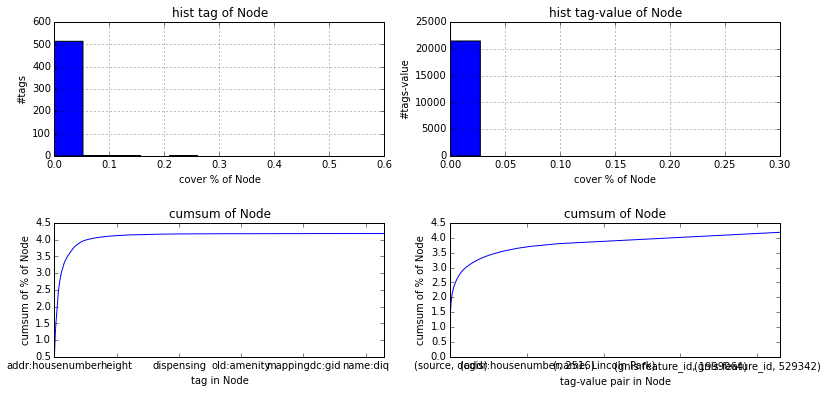

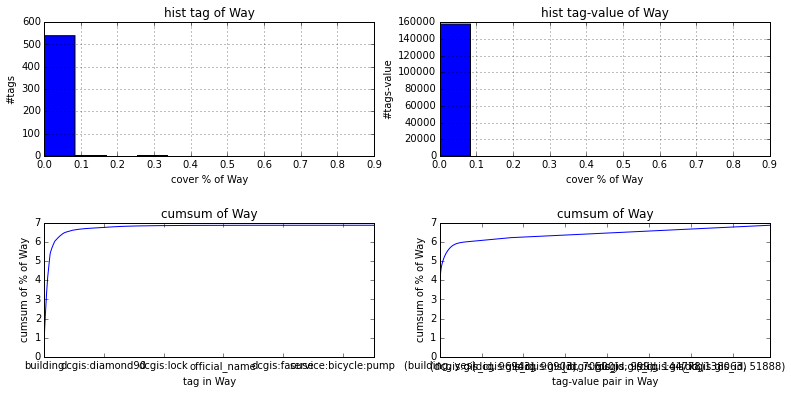

In [276]:
plot_statistic(key_cnt_DC_NODES, key_value_cnt_DC_NODES, len_NODES_with_tags, 'Node')
plot_statistic(key_cnt_DC_WAYS, key_value_cnt_DC_WAYS, len_WAYS_with_tags, 'Way')

for key value plotting, can I build a interactive distribution? Because there are so many keys. Of course I can plot one for each key
**Solved by using plotly**

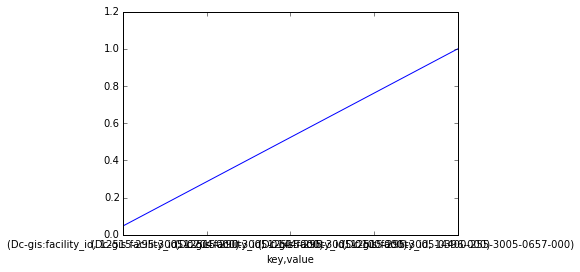

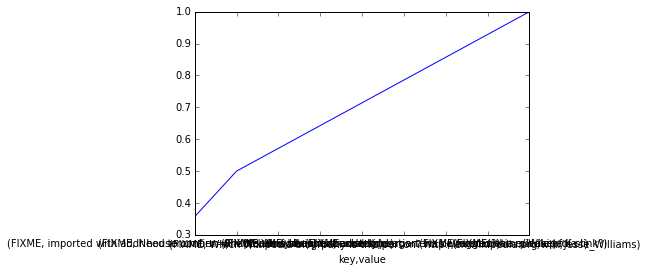

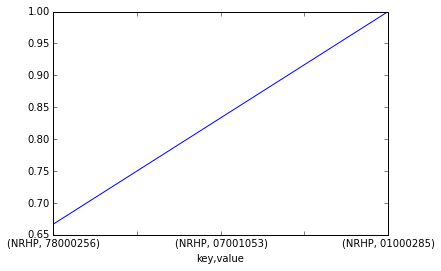

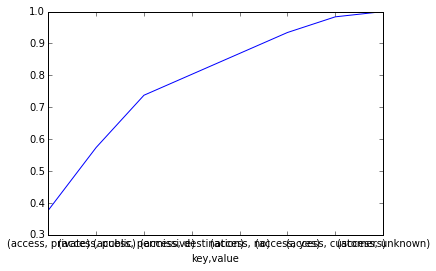

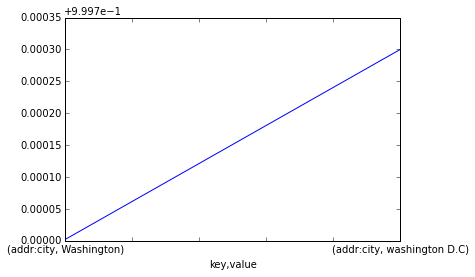

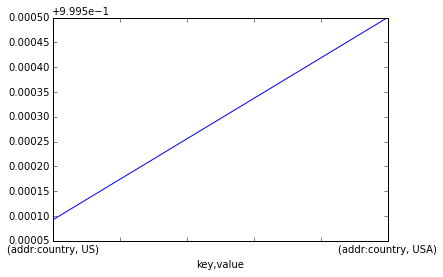

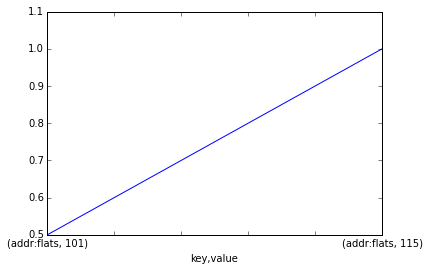

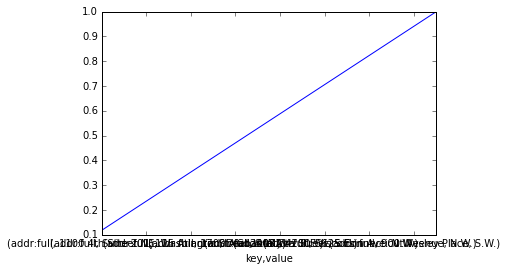

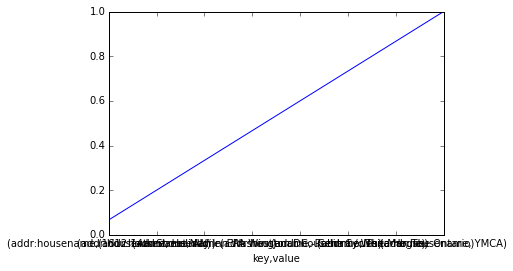

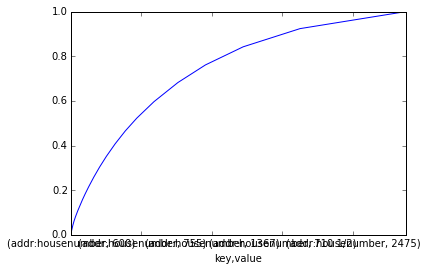

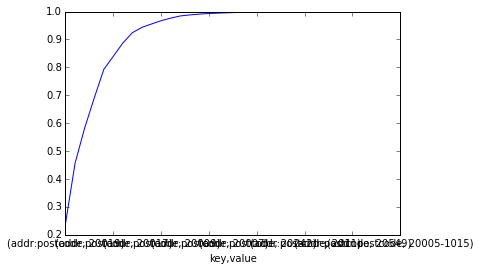

In [206]:
cnt = 0
for tag, values in key_value_cnt_DC_NODES.groupby(level=0):
    tag_values_df = values.copy()
    len_nodes_with_one_tag = tag_values_df.oid.sum()
    tag_values_df['pct.'] = tag_values_df/len_nodes_with_one_tag
    tag_values_df['cum'] = tag_values_df['pct.'].cumsum()
#     display(tag_values_df)
    if tag_values_df.shape[0]>1:
        cnt+=1
        plt.figure()
        tag_values_df.cum.plot()
#         tag_values_df['pct.'].hist()
        if cnt>10:
            break

# plotly function, without tag_of interest flitering function

In [17]:
OUTPUT_DIR_FOR_GRAPH = OUTPUT_DIR+'OSM tags graphs/'

def plot_tags_value_cnt(tags_value_cnt, len_objs, otype):
    x_pct = ['%s=%s' %(tag, value) for tag, value in tags_value_cnt.index.tolist()]
    y_pct = tags_value_cnt['pct.'].values.tolist()
    plotly.offline.plot({"data":[go.Bar(x=x_pct, y=y_pct)], 
                         "layout":go.Layout(title='percentage of tag=value in {} {}'.format(len_objs, otype))},
                       filename=OUTPUT_DIR_FOR_GRAPH+"tags_value_pct_%s.html" % otype)
    
    x_cumpct = ['']+x_pct
    y_cumpct = tags_value_cnt['cum'].values.tolist()
    plotly.offline.plot({"data":[go.Scatter(x=x_cumpct, y=y_cumpct)], 
                         "layout":go.Layout(title="cumulative percentage of tag=value in {} {}".format(len_objs, otype))},
                    filename=OUTPUT_DIR_FOR_GRAPH+"tags_value_cumpct_%s.html" % otype)
    
    
def plot_tags_cnt(tags_cnt, len_objs, otype):
    x_pct = tags_cnt.index.tolist()
    y_pct = tags_cnt['pct.'].values.tolist()
    plotly.offline.plot({"data":[go.Bar(x=x_pct, y=y_pct)], 
                         "layout":go.Layout(title='percentage of tags in {} {}'.format(len_objs, otype))},
                       filename=OUTPUT_DIR_FOR_GRAPH+"tags_pct_%s.html" % otype)

    x_cumpct=['']+ x_pct
    y_cumpct=[0]+tags_cnt.cum.values.tolist()
    plotly.offline.plot({"data":[go.Scatter(x=x_cumpct, y=y_cumpct)], 
                         "layout":go.Layout(title="cumulative percentage of tags in {} {}".format(len_objs, otype))},
                        filename=OUTPUT_DIR_FOR_GRAPH+"tags_cumpct_%s.html" % otype)
    

def plot_indvd_tags_in_one_html(tags_in_order, tags_value_cnt, len_objs, otype):
    data_cumsum = []
    data_pct = []
    for tag in tags_in_order:
        values = tags_value_cnt.loc[tag].copy()
        len_osm_objs = values.cnt.sum()
        len_values = values.shape[0]
        
        # percentage: len(nodes with tag=value)/len(nodes with tag=*)
        values['pct.'] = values.cnt/len_osm_objs
        values['cum'] = values['pct.'].cumsum()
        
        x_cumpct = [i for i in range(len_values+1)]
        y_cumpct = [0] + values['cum'].tolist()
        name = '{}: {} {}'.format(tag, len_osm_objs, otype)
        data_cumsum.append(go.Scatter(x=x_cumpct, y=y_cumpct, name=name, visible='legendonly'))
        
        x_pct = [i for i in range(len_values)]
        y_pct = values['pct.'].tolist()
        data_pct.append(go.Scatter(x=x_pct, y=y_pct, name=name, visible='legendonly'))

    plotly.offline.plot({"data": data_cumsum, 
                         "layout": go.Layout(title="cumulative percentage of tag=values in each tag for {} {}".format(len_objs, otype))}, 
                         filename=OUTPUT_DIR_FOR_GRAPH+'individual_tags_cumpct_%s.html' % otype)
    plotly.offline.plot({"data": data_pct, "layout": go.Layout(title="percentage of tag=values in each tag for {} {}".format(len_objs, otype))}, 
                         filename=OUTPUT_DIR_FOR_GRAPH+'individual_tags_pct_%s.html' % otype)
